# Pronóstico de la evolución de pacientes con diabetes

## Descripción del problema real

Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

## Descripción del problema en términos de los datos

Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo `datos/diabetes.csv`. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

## Requerimientos

Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

### Imports

In [9]:
import tensorflow as tf
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LRM
import copy
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold as KF
def encadenar(i,lista):
    nlista = copy.deepcopy(lista)
    nlista.append(i)
    return nlista
    

# Algoritmo forward, para elección de variables

In [10]:
def forward(keys, skeys, X, mseh, itera):
    itera = itera +1
    d = X.loc[:,'Y']
    ikey=0
    l = len(mseh)-1
    if(len(skeys)==0):  
        for i in keys:
            x_sm = sm.add_constant(X.loc[:,i])
            model = sm.OLS(d, x_sm)
            results = model.fit()
            results.summary()
            mse = results.mse_total
            if(mse<mseh[0][1]):
                mseh[0] = [i,mse,ikey]
            ikey = ikey +1
    else:   
        for i in keys: 
            k = encadenar(i,skeys)
            x_sm = sm.add_constant(X.loc[:,k])
            model = sm.OLS(d, x_sm)
            results = model.fit()
            results.summary()
            mse = results.mse_total
            if(mse<mseh[l][1] and mse<mseh[l-1][1]):
                
                mseh[l] = [i,mse,ikey]
            ikey = ikey +1
    
           
    skeys.append(keys.pop(mseh[l][2]))
    if(len(keys)==0):
        dkeys = []
        for j in mseh:
            if(not(j[0]=='')):
                dkeys.append(j[0])
        return (dkeys,mseh[l-1][1])
    
    mseh.append(['',100000,0])
    return forward(keys,skeys,X,mseh, itera)


# Carga de datos y ejecución de forward

In [11]:

X = pd.read_csv('./datos/diabetes.csv')
key = []
for i in X.keys():
    key.append(i)
    
ind = 0
key.pop(10)
    
(dkeys,mse) = forward(key,[], X, [['',100000,0]], 0)
# Regresión Lineal del mejor modelo
print(mse," Vars elegidas: ",dkeys)

5943.331347923785  Vars elegidas:  ['age', 'bmi', 's1', 's3', 's5']


### Entrenamiento y evaluación del modelo elegido

In [12]:
d = X['Y']
X_train, X_test, Y_train, Y_test =tts( X.loc[:,dkeys], d, test_size = 0.2, random_state=101)
lrm = LRM()
lrm.fit(X_train,Y_train)
Y_pred = lrm.predict(X_test)
print("MSE LM", skm.mean_squared_error(Y_test,Y_pred))


MSE LM 3090.1574454790425


### Eelección del mdelo de redes neuronales

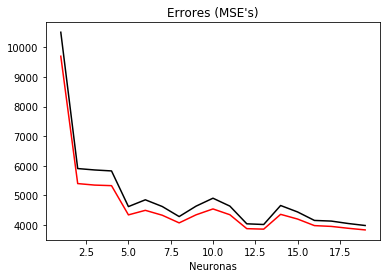

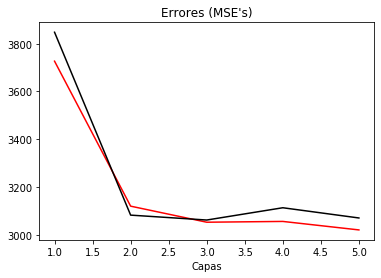

In [13]:

edad = tf.feature_column.numeric_column('age')
imc = tf.feature_column.numeric_column('bmi')
s1 = tf.feature_column.numeric_column('s1')
s3 = tf.feature_column.numeric_column('s3')
s5 = tf.feature_column.numeric_column('s5')

columnas = [edad, imc, s1, s3, s5]

funcion = tf.estimator.inputs.pandas_input_fn(
    x = X_train, 
    y= Y_train, 
    batch_size=10,
    num_epochs=2500, 
    shuffle=True)



E_train_hist = []
E_test_hist = []

cneuron = [0,100000000]

pasos = 5000
for i in range(1,20):
    m = tf.estimator.DNNRegressor(
        hidden_units=[i], 
        feature_columns=columnas)
    m.train(input_fn= funcion, steps=pasos)
    
    test_funcion = tf.estimator.inputs.pandas_input_fn(
        x= X_train, 
        batch_size=10, 
        num_epochs=1, 
        shuffle=False
        )
    
    predicciones = []
    
    for j in list(m.predict(test_funcion)):
        predicciones.append(j['predictions'])
   
    train_funcion = tf.estimator.inputs.pandas_input_fn(
        x= X_test, 
        batch_size=10, 
        num_epochs=1, 
        shuffle=False
        )
    
    evaluaciones = []
    
    for j in list(m.predict(train_funcion)):
        evaluaciones.append(j['predictions'])
    
    if(skm.mean_squared_error(predicciones, Y_train)<cneuron[1]):
        cneuron = [i,skm.mean_squared_error(predicciones, Y_train)]
    E_train_hist.append(skm.mean_squared_error(predicciones, Y_train))
    E_test_hist.append(skm.mean_squared_error(evaluaciones, Y_test))
    
plt.figure()
plt.title("Errores (MSE's)")
plt.xlabel("Neuronas")
plt.plot(range(1,20) ,E_train_hist,  '-', color="red");
plt.plot(range(1,20) ,E_test_hist, '-', color="black");
    
#buscamos la cantidad de capas 
capas = [[cneuron[0]],[cneuron[0],cneuron[0]],[cneuron[0],cneuron[0],cneuron[0]],[cneuron[0],cneuron[0],cneuron[0],cneuron[0]],[cneuron[0],cneuron[0],cneuron[0],cneuron[0],cneuron[0]]]
   
ccapas = [0,1000000000]
E_train_hist = []
E_test_hist = []
for i in capas:
    m = tf.estimator.DNNRegressor(
        hidden_units=i, 
        feature_columns=columnas)
    m.train(input_fn= funcion, steps=pasos)
    
    test_funcion = tf.estimator.inputs.pandas_input_fn(
        x= X_train, 
        batch_size=10, 
        num_epochs=1, 
        shuffle=False
        )
    
    predicciones = []
    
    for j in list(m.predict(test_funcion)):
        predicciones.append(j['predictions'])
   
    train_funcion = tf.estimator.inputs.pandas_input_fn(
        x= X_test, 
        batch_size=10, 
        num_epochs=1, 
        shuffle=False
        )
    
    evaluaciones = []
    
    for j in list(m.predict(train_funcion)):
        evaluaciones.append(j['predictions'])
    
    
    E_train_hist.append(skm.mean_squared_error(predicciones, Y_train))
    E_test_hist.append(skm.mean_squared_error(evaluaciones, Y_test))
    
    if(skm.mean_squared_error(predicciones, Y_train)<ccapas[1]):
        ccapas = [i,skm.mean_squared_error(predicciones, Y_train)]
    
plt.figure()
plt.title("Errores (MSE's)")
plt.xlabel("Capas")
plt.plot([1,2,3,4,5], E_train_hist,  '-', color="red");
plt.plot([1,2,3,4,5], E_test_hist, '-', color="black");
    


### Entrenamiento y evaluación del modelo elegido de redes neuronales

#### Se elige el mejor modelo

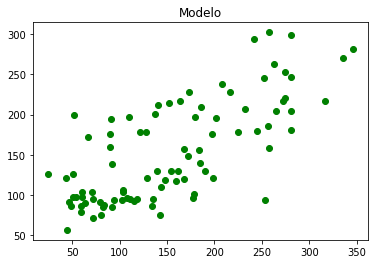

In [14]:

for i in [ccapas[0]]:
    m = tf.estimator.DNNRegressor(
        hidden_units=i, 
        feature_columns=columnas)
    m.train(input_fn= funcion, steps=pasos)
    
    test_funcion = tf.estimator.inputs.pandas_input_fn(
        x= X_test, 
        batch_size=10, 
        num_epochs=1, 
        shuffle=False
        )
    
    predicciones = []
    
    for j in list(m.predict(test_funcion)):
        predicciones.append(j['predictions'])
   
print("MSE Modelo elegido ", skm.mean_squared_error(predicciones,Y_test))       
plt.figure()
plt.title("Modelo")
plt.scatter(Y_test,predicciones,color="green")





## validación cruzada 

In [15]:

def validacion(indice_entren, indice_test, X, Y, keys):
    
    X_train = X.iloc[indice_entren,:]
    X_test = X.iloc[indice_test,:]
    Y_train = Y.iloc[indice_entren]
    Y_test = Y.iloc[indice_test]
        
    X_test.columns=keys
    X_train.columns=keys
        
    edad = tf.feature_column.numeric_column('age')
    imc = tf.feature_column.numeric_column('bmi')
    s1 = tf.feature_column.numeric_column('s1')
    s3 = tf.feature_column.numeric_column('s3')
    s5 = tf.feature_column.numeric_column('s5')

    columnas = [edad, imc, s1, s3, s5]
    
    funcion = tf.estimator.inputs.pandas_input_fn(
        x = X_train, 
        y= Y_train, 
        batch_size=10,
        num_epochs=2500, 
        shuffle=True)
    
    m = tf.estimator.DNNRegressor(
        hidden_units=[3,3], 
        feature_columns=columnas)
    m.train(input_fn= funcion, steps=pasos)
        
    test_funcion = tf.estimator.inputs.pandas_input_fn(
        x= X_test, 
        batch_size=10, 
        num_epochs=1, 
        shuffle=False
        )
        
    predicciones = []
        
    for j in list(m.predict(test_funcion)):
        predicciones.append(j['predictions'])
            
    return skm.mean_squared_error(predicciones,Y_test)
    
kf = KF(n_splits=4)

crossval = []
X1 = X.loc[:,dkeys]

for indice_entren, indice_test in kf.split(X):
    crossval.append(validacion(indice_entren,indice_test, X1, X['Y'], dkeys))

print("")
print("MSE Validación cruzada: ", sum(crossval)/len(crossval))    



MSE Validación cruzada:  10261.149212623011
